# Mod 3 Project

Student: Zach Zazueta  
Pace: Part time  
Project review date/time: Nov. 14th 2019  
Instructor: Abhineet Kulkarni  
Blog: <link>

## Business Case

We are running analysis for Northwind Enterprises

### Questions to answer:
1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Is there a difference in the mean "time-to-ship" (time between Order Date and Ship Date" between the 3 shippers?
3. Is there is significant difference in freight cost depending on which shipper you use?
4. Do customers who receive a discount on their first order return for more lifetime orders than those who do not?

#### Package Imports

In [1]:
import pandas as pd
import numpy as np
from numpy import std, mean, sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import seaborn as sns
import sqlite3
from sqlite3 import Error
import itertools
from statsmodels.stats.power import TTestIndPower, TTestPower
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
from ProjFunc import get_sample, get_sample_mean, cohens_d

#### Establish a connection to the data

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
table_names = pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', conn)
table_names = table_names.drop([5,8,9], axis=0)

tn_list = table_names.name
select_template = 'SELECT * FROM {name}'
fd = {}
for tn in tn_list:
    query = select_template.format(name = tn)
    fd[tn] = pd.read_sql(query, conn)
    
fd["Order"] = pd.read_sql('''SELECT * FROM "Order"''', conn)

In [5]:
#Making a df for each of the tables generated from the SQL tables

Ordr = pd.DataFrame(fd["Order"])
Employee = pd.DataFrame(fd["Employee"])
Category = pd.DataFrame(fd["Category"])
Customer = pd.DataFrame(fd["Customer"])
Shipper = pd.DataFrame(fd["Shipper"])
Supplier = pd.DataFrame(fd["Supplier"])
Product = pd.DataFrame(fd["Product"])
OrderDetail = pd.DataFrame(fd["OrderDetail"])
Region = pd.DataFrame(fd["Region"])
Territory = pd.DataFrame(fd["Territory"])
EmployeeTerritory = pd.DataFrame(fd["EmployeeTerritory"])

### EDA

In [6]:
#This investigates the revenue by month with and without a discount

Historical_Sales = pd.merge(Ordr, OrderDetail, left_on='Id', right_on='OrderId', how='left')
Historical_Sales.OrderDate = pd.to_datetime(Historical_Sales.OrderDate, infer_datetime_format=True)
Historical_Sales.RequiredDate = pd.to_datetime(Historical_Sales.RequiredDate, infer_datetime_format=True)
Historical_Sales.ShippedDate = pd.to_datetime(Historical_Sales.ShippedDate, infer_datetime_format=True)

Historical_Sales['Month'] = Historical_Sales.OrderDate.map(lambda x: 100*x.year + x.month)
Historical_Sales['Revenue'] = (Historical_Sales.UnitPrice * (1 - Historical_Sales.Discount)) * Historical_Sales.Quantity
Historical_Sales['Full_price_rev'] = (Historical_Sales.UnitPrice) * Historical_Sales.Quantity
Historical_Sales['Discount_dollars'] = Historical_Sales['Full_price_rev'] - Historical_Sales['Revenue']

In [7]:
Sales_by_date = Historical_Sales.groupby('Month').Revenue.sum()
Sales_by_date = Sales_by_date.to_frame()
Sales_by_date = Sales_by_date.reset_index()
Sales_by_date = Sales_by_date.drop([22], axis=0) #dropping the last month because it seems likely incomplete

In [8]:
Proj_by_date = Historical_Sales.groupby('Month').Full_price_rev.sum()
Proj_by_date = Proj_by_date.to_frame()
Proj_by_date = Proj_by_date.reset_index()
Proj_by_date = Proj_by_date.drop([22], axis=0) #dropping the last month because it seems likely incomplete

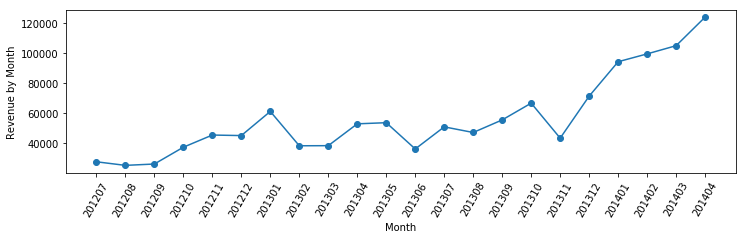

In [9]:
#Generating a plot for the revenue of NorthWinds over time

t = [str(i) for i in Sales_by_date.Month]

x = Sales_by_date.Revenue
y = Proj_by_date.Full_price_rev

plt.figure(figsize=(12,3))

plt.ylabel('Revenue by Month')
plt.xlabel('Month')
plt.xticks(range(len(t)), t, rotation=60)

plt.plot(x, marker="o");

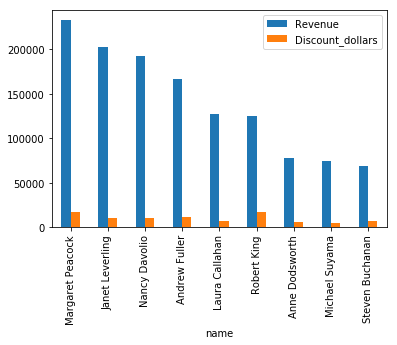

In [10]:
#Now to take a look at sales vs. employee and location

Sales_by_emp = Historical_Sales[['OrderId', 'EmployeeId', 'Month', 'ProductId', 'Revenue', 'Full_price_rev', 'Discount_dollars']]
Emp_name = Employee[['Id','FirstName', 'LastName']]
Emp_name['name'] = Emp_name.FirstName + " " + Emp_name.LastName
Sales_by_emp = pd.merge(Sales_by_emp, Emp_name, left_on='EmployeeId', right_on='Id')
Sales_by_emp_sub = Sales_by_emp[['name', 'Revenue', 'Discount_dollars']]
Sales_by_emp_sub.groupby('name').sum().sort_values('Revenue', ascending=False).plot(kind='bar');
#Sales_by_emp_sub.groupby('name').sum().sort_values('Discount_dollars', ascending=False).plot(kind='bar');

In [11]:
l = Sales_by_emp.groupby('Month').Discount_dollars.sum()
l = l.to_frame()
l = l.reset_index()
l = l[:22]

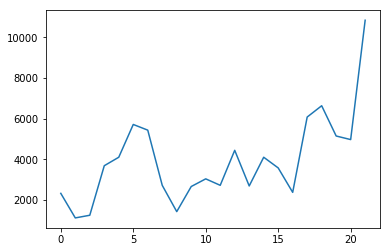

In [12]:
plt.plot(l.Discount_dollars);

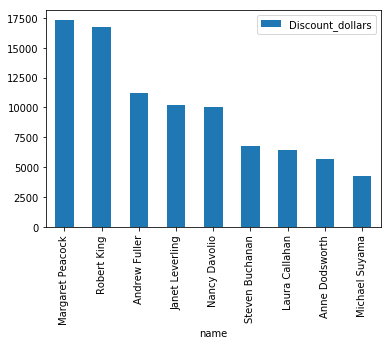

In [13]:
Sales_by_emp = Historical_Sales[['OrderId', 'EmployeeId', 'Month', 'ProductId', 'Revenue', 'Full_price_rev', 'Discount_dollars']]
Emp_name = Employee[['Id','FirstName', 'LastName']]
Emp_name['name'] = Emp_name.FirstName + " " + Emp_name.LastName
Sales_by_emp = pd.merge(Sales_by_emp, Emp_name, left_on='EmployeeId', right_on='Id')
Sales_by_emp_sub = Sales_by_emp[['name', 'Discount_dollars']]
Sales_by_emp_sub.groupby('name').sum().sort_values('Discount_dollars', ascending=False).plot(kind='bar');

In [14]:
Product_Cats = {1: 'Beverages', 2: 'Sauces', 3: 'Breads/Cookies', 4: 'Cheese', 5: 'Pasta', 6: 'Meats', 7: 'Fruit/Tofu/Sauerkraut', 8: 'Fish/Seafood'}

In [15]:
cur.execute('''SELECT p.CategoryId, SUM(od.Quantity)
               FROM Product p
               JOIN OrderDetail od ON p.Id = od.ProductId
               GROUP BY CategoryId;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]

In [16]:
cur.execute('''SELECT p.CategoryId, substr(o.OrderDate,1,7) AS YearMonth, SUM(od.Quantity) AS Quantity
               FROM "Order" o
               JOIN OrderDetail od ON o.Id = od.OrderId
               JOIN Product p ON od.ProductId = p.Id
               GROUP BY p.CategoryId, YearMonth
               Order By YearMonth;''')
emp_sales = pd.DataFrame(cur.fetchall())
emp_sales.columns = [i[0] for i in cur.description]
emp_sales = emp_sales[:176]

### Case 1: Does dicount amount have a significant effect on the quantity of product in an order? If so, at what level(s) of discount?
H_o: The mean number of products sold does not change if there is a discount  
H_a: The mean number of products sold increases as the discount increases

In [17]:
#pull in the OrderDetail table

cur.execute('''SELECT * FROM OrderDetail;''')

total_quant_per_ord = pd.DataFrame(cur.fetchall())
total_quant_per_ord.columns = [i[0] for i in cur.description]

In [18]:
#remove the discount levels of 1-4% and 6% due to the low number of occurances of those levels of discount
total_quant_per_ord = total_quant_per_ord[total_quant_per_ord['Discount'] != 0.06]
total_quant_per_ord = total_quant_per_ord[total_quant_per_ord['Discount'] != 0.04]
total_quant_per_ord = total_quant_per_ord[total_quant_per_ord['Discount'] != 0.03]
total_quant_per_ord = total_quant_per_ord[total_quant_per_ord['Discount'] != 0.02]
total_quant_per_ord = total_quant_per_ord[total_quant_per_ord['Discount'] != 0.01]

In [19]:
#run ANOVA on discount vs quantity sold
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, total_quant_per_ord).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


In [20]:
#Bonferroni Correction
bc_pval1 = 0.05/6
bc_pval1

0.008333333333333333

There are 6 discount groups so the adjusted p-value we need to test against is 0.008. The initial ANOVA speculation showed a p-value less than that (2.84 e-09) so we can still interpret Discount to have a significant impact on quantity of goods sold. We'll proceed with more detailed analysis.

In [21]:
#split the data into frames based on the level of discount
dis_0 = total_quant_per_ord[total_quant_per_ord['Discount'] == 0.00]
dis_5 = total_quant_per_ord[total_quant_per_ord['Discount'] == 0.05]
dis_10 = total_quant_per_ord[total_quant_per_ord['Discount'] == 0.10]
dis_15 = total_quant_per_ord[total_quant_per_ord['Discount'] == 0.15]
dis_20 = total_quant_per_ord[total_quant_per_ord['Discount'] == 0.20]
dis_25 = total_quant_per_ord[total_quant_per_ord['Discount'] == 0.25]

discounts = [dis_0, dis_5, dis_10, dis_15, dis_20, dis_25]

#check to see that we have sufficient sized groups
for d in discounts:
    print(len(d))

1317
185
173
157
161
154


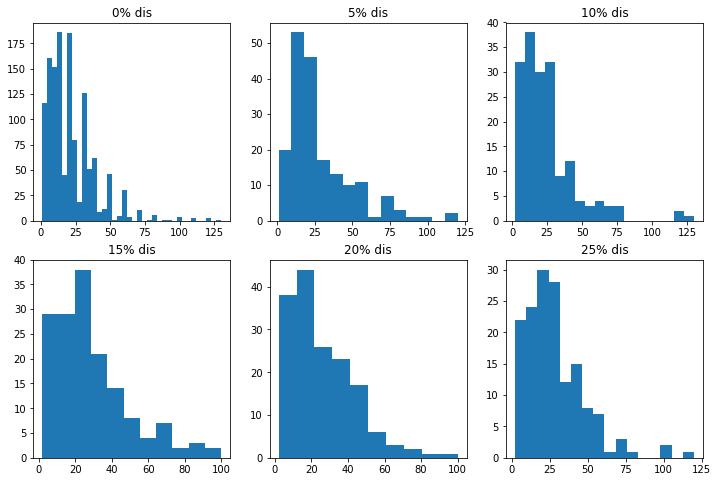

In [22]:
#run a quick visual check on normality of the means of quantity sold at each distribution level

fig, axs = plt.subplots(2,3, figsize = (12,8))
axs[0,0].hist(dis_0.Quantity, bins='auto')
axs[0,0].set_title('0% dis')
axs[0,1].hist(dis_5.Quantity, bins='auto')
axs[0,1].set_title('5% dis')
axs[0,2].hist(dis_10.Quantity, bins='auto')
axs[0,2].set_title('10% dis')
axs[1,0].hist(dis_15.Quantity, bins='auto')
axs[1,0].set_title('15% dis')
axs[1,1].hist(dis_20.Quantity, bins='auto')
axs[1,1].set_title('20% dis')
axs[1,2].hist(dis_25.Quantity, bins='auto')
axs[1,2].set_title('25% dis');

In [23]:
#we can reject the null that these are normal populations - p value (second value) is less than 0.05 
#so we have sufficient evidence to reject the null.

for d in discounts:
    print(stats.shapiro(d.Quantity))

(0.8434571027755737, 3.803856556577728e-34)
(0.8356332778930664, 3.5543719660233175e-13)
(0.8002723455429077, 4.159971249851485e-14)
(0.8827876448631287, 8.372069704165597e-10)
(0.9130357503890991, 3.249125413162801e-08)
(0.8902021646499634, 2.6962121424389807e-09)


In [24]:
#from Project_functions import *
n=30
tests = 100

In [25]:
#generate a list of sample means of quantity of products sold for each discount level
Zero = get_sample_mean(dis_0.Quantity)
Five = get_sample_mean(dis_5.Quantity)
Ten = get_sample_mean(dis_10.Quantity)
Fifteen = get_sample_mean(dis_15.Quantity)
Twenty = get_sample_mean(dis_20.Quantity)
Twentyfive = get_sample_mean(dis_25.Quantity)

In [26]:
#check to see if the lists tend to have the same variance
#null hypothesis is that all samples are from populations with equal variances. Because p > 0.05, 
#we do not have evidence to reject the null hypothesis.
stats.levene(Zero, Five, Ten, Fifteen, Twenty, Twentyfive) 

LeveneResult(statistic=1.1466412950827223, pvalue=0.33441416152052805)

For the 5, 15, 20, and 25 % discounts, a sample size of just 30 orders will have a power of at least .8, which means that 80% of the time, we will reject the null hypothesis when it is false.

In [27]:
combs = [['5%',(Zero, Five)], ['10%',(Zero, Ten)], ['15%',(Zero, Fifteen)], 
         ['20%',(Zero, Twenty)], ['25%',(Zero, Twentyfive)]]

I will now compare each discount level against the sales that did not receive a discount to determine a p-value with which I can assess my null hypothesis. I will test each pair for equal variance. If the null hypothesis is rejected for the levene test, then the pair have unequal variance and I would use Welch's ttest to compare the two sample distributions for significant;y different means. If the null for levene is not rejected then the variances are the same and I will use Student's ttest to compare sample means.

In [28]:
for i in combs:
    if stats.levene(i[1][0], i[1][1])[1] < 0.05:
        print('The population of orders at the {} discount level and those at 0% do not have the same variance. That means we will perform Welchs t-test'.format(i[0]))
        ttest = stats.ttest_ind(i[1][0], i[1][1], equal_var=False)
        if ttest[1] < 0.05:
            print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean quantity of items sold from the populations for no discount and those with {} discount are not statistically different'.format(ttest[1],i[0]))
        else:
            print('The p-value for the ttest is {} which is greater than 0.05. That means I do not have sufficient evidence to reject the null hypothesis, inherently accepting there is no difference between mean goods sold at 0 discount and mean goods sold at {} discount.'.format(ttest[1],i[0]))
    else:
        print('The population of orders at the {} discount level and those at 0% do have the same variance. That means we will perform Students t-test'.format(i[0]))
        ttest = stats.ttest_ind(i[1][0], i[1][1])
        if ttest[1] < 0.05:
            print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean quantity of items sold from the populations for no discount and those with {} discount are not statistically different'.format(ttest[1],i[0]))
        else:
            print('The p-value for the ttest is {} which is greater than 0.05. That means I do not have sufficient evidence to reject the null hypothesis, inherently accepting there is no difference between mean goods sold at 0 discount and mean goods sold at {} discount.'.format(ttest[1],i[0]))

The population of orders at the 5% discount level and those at 0% do have the same variance. That means we will perform Students t-test
The p-value for the ttest is 2.9672995974628607e-26 which is less than 0.05. That means I will reject the null hypothesis that the mean quantity of items sold from the populations for no discount and those with 5% discount are not statistically different
The population of orders at the 10% discount level and those at 0% do have the same variance. That means we will perform Students t-test
The p-value for the ttest is 8.612447197839862e-11 which is less than 0.05. That means I will reject the null hypothesis that the mean quantity of items sold from the populations for no discount and those with 10% discount are not statistically different
The population of orders at the 15% discount level and those at 0% do have the same variance. That means we will perform Students t-test
The p-value for the ttest is 4.552552178315195e-35 which is less than 0.05. That

We now need to determine what effect size we need to obtain a power level of 0.8 given our number of obs (30 per sample) and our alpha. Alpha remains 0.05 because we are just comparing two groups at a time, instead of all 6 like we did in the ANOVA.

In [29]:
power_analysis = TTestIndPower()
power_analysis.solve_power(nobs1=30, alpha=.05, power=.8)

0.7356198424871596

In [31]:
for i in combs:
    cd = cohens_d(i[1][0], i[1][1])
    power = power_analysis.solve_power(effect_size=cd, nobs1=30, alpha=.05)
    print('The effect size between the 0% discount level and the {} discount level is {}. Given our sample size of 30, and an alpha level of 0.05, our power is determined to be {}'.format(i[0], cd, power))

The effect size between the 0% discount level and the 5% discount level is 1.7419888520916629. Given our sample size of 30, and an alpha level of 0.05, our power is determined to be 1.0
The effect size between the 0% discount level and the 10% discount level is 0.9701213677434041. Given our sample size of 30, and an alpha level of 0.05, our power is determined to be 0.9585755039869618
The effect size between the 0% discount level and the 15% discount level is 2.148677405680175. Given our sample size of 30, and an alpha level of 0.05, our power is determined to be 1.0
The effect size between the 0% discount level and the 20% discount level is 1.4150428128531234. Given our sample size of 30, and an alpha level of 0.05, our power is determined to be 0.9996957853998275
The effect size between the 0% discount level and the 25% discount level is 1.5730895750967406. Given our sample size of 30, and an alpha level of 0.05, our power is determined to be 0.9999720065566928


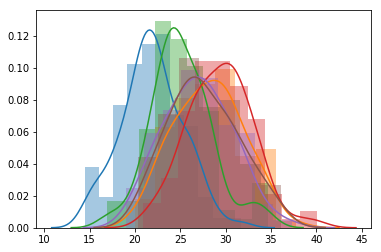

In [32]:
sns.distplot(Zero)
sns.distplot(Five)
sns.distplot(Ten)
sns.distplot(Fifteen)
sns.distplot(Twenty)
sns.distplot(Twentyfive);

In [33]:
for i in combs:
    print('Difference in average goods sold between {} discount level and 0% discount is: '.format(i[0]), round(np.mean(i[1][1]) - np.mean(i[1][0]),2))

Difference in average goods sold between 5% discount level and 0% discount is:  6.22
Difference in average goods sold between 10% discount level and 0% discount is:  3.29
Difference in average goods sold between 15% discount level and 0% discount is:  7.47
Difference in average goods sold between 20% discount level and 0% discount is:  5.06
Difference in average goods sold between 25% discount level and 0% discount is:  5.67


### Case 2 - Is there a difference in the mean "time to ship" between the 3 shippers?

Time to ship (tts) is determined to be the time in days between the order date and the ship date for an order.  
H_o: There is no difference between the time to ship for the three shippers  
H_a: There is a difference between tts when comparing the shippers

In [34]:
Historical_Sales['TTS'] = Historical_Sales['ShippedDate'] - Historical_Sales['OrderDate']
Historical_Sales['tts'] = Historical_Sales['TTS'].dt.days

Run an ANOVA on the Shipper vs tts to see if there is significance

In [35]:
formula = 'tts ~ C(ShipVia)'
lm = ols(formula, Historical_Sales).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(ShipVia)    748.990774     2.0  8.419976  0.000228
Residual    92467.709034  2079.0       NaN       NaN


In [36]:
bc_pval2 = 0.05/3
bc_pval2

0.016666666666666666

There are 3 shippers so the adjusted p-value we need to test against is 0.0167. The initial ANOVA speculation showed a p-value less than that (0.00023) so we can still interpret Shipper to have a significant impact on the time for a product to ship. We'll proceed with more detailed analysis.

Separate into ShipVia 1,2,3 and then TTS (time to ship)

In [37]:
Ship1 = Historical_Sales[Historical_Sales['ShipVia'] == 1]
Ship2 = Historical_Sales[Historical_Sales['ShipVia'] == 2]
Ship3 = Historical_Sales[Historical_Sales['ShipVia'] == 3]

#I just want to work with just tts, so I strip that out, group the data by Order, set them back to frames, and drop NAs.
Ship1 = Ship1[['OrderId','tts']]
Ship1 = Ship1.groupby('OrderId').tts.mean()
Ship1 = Ship1.to_frame()
Ship1 = Ship1.reset_index()
Ship1 = Ship1.dropna()
Ship2 = Ship2[['OrderId','tts']]
Ship2 = Ship2.groupby('OrderId').tts.mean()
Ship2 = Ship2.to_frame()
Ship2 = Ship2.reset_index()
Ship2 = Ship2.dropna()
Ship3 = Ship3[['OrderId','tts']]
Ship3 = Ship3.groupby('OrderId').tts.mean()
Ship3 = Ship3.to_frame()
Ship3 = Ship3.reset_index()
Ship3 = Ship3.dropna()

In [38]:
ships = [Ship1, Ship2, Ship3]

In [39]:
for ship in ships:
    print(len(ship))

245
315
249


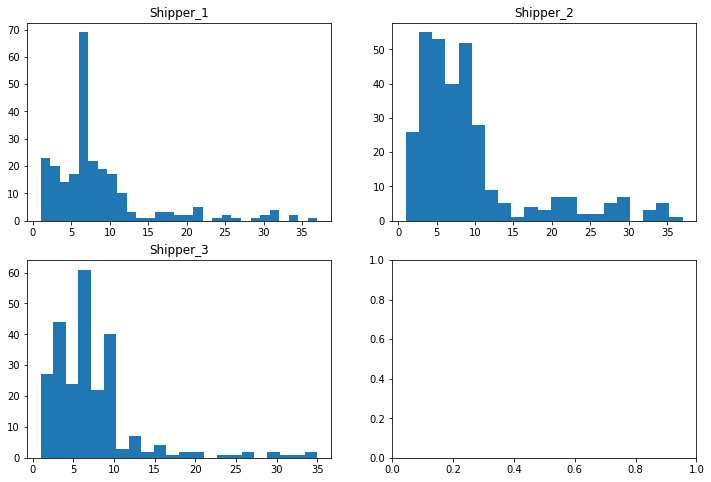

In [40]:
#initial visual check for normality

x = Ship1.tts
y = Ship2.tts
z = Ship3.tts

fig, axs = plt.subplots(2,2, figsize = (12,8))
axs[0,0].hist(x, bins='auto')
axs[0,0].set_title('Shipper_1')
axs[0,1].hist(y, bins='auto')
axs[0,1].set_title('Shipper_2')
axs[1,0].hist(z, bins='auto')
axs[1,0].set_title('Shipper_3');

In [41]:
#run the shapiro test and expect none of the groups to be normal
for ship in ships:
    print(stats.shapiro(ship.tts))

(0.76434725522995, 1.8659610568323265e-18)
(0.7721602320671082, 1.2729976008447947e-20)
(0.745414137840271, 2.63342874173607e-19)


The p value for the Shapiro test is < 0.05 for each Shipper, which means we have evidence to reject the null that the tts are normally distributed for any of the shippers.

To get normal data, I will use the CLT to test distributions of sample means to use to check for variance.

In [42]:
S1 = get_sample_mean(Ship1.tts)
S2 = get_sample_mean(Ship2.tts)
S3 = get_sample_mean(Ship3.tts)

stats.levene(S1, S2, S3)

LeveneResult(statistic=3.497045564109253, pvalue=0.03153981344123662)

The inital levene tests were widely varied (I ran the above code a few times) I ran 100 samples of size n=30 from each population 100 times and took the levene test each time.

In [43]:
p = []
for i in range(0,100):
    S1 = get_sample_mean(Ship1.tts)
    S2 = get_sample_mean(Ship2.tts)
    S3 = get_sample_mean(Ship3.tts)
    if stats.levene(S1, S2, S3)[1] < 0.05:
        p.append(1)

print("Only {} out of 100 times did I get a p-value from the levene test that would allow me to reject the null that the data come from a population with equal variance, so I would expect to use the Student's test ~30-40% of the time.".format(sum(p)))

Only 69 out of 100 times did I get a p-value from the levene test that would allow me to reject the null that the data come from a population with equal variance, so I would expect to use the Student's test ~30-40% of the time.


In [44]:
scombs = [['Speedy Express & United Package',(S1, S2)], ['Speedy Express & Federal Shipping', (S1, S3)], ['United Package & Federal Shipping', (S2, S3)]]

In [45]:
for i in scombs:
    if stats.levene(i[1][0], i[1][1])[1] < 0.05:
        print('The population of mean tts for my samples for shippers {} do not have the same variance so I will perform Welchs t-test'.format(i[0]))
        ttest = stats.ttest_ind(i[1][0], i[1][1], equal_var=False)
        if ttest[1] < 0.05:
            print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean tts between shippers {} is not statistically different'.format(ttest[1],i[0]))
        else:
            print('The p-value for the ttest is {} which is less than 0.05. That means I do not have sufficient evidence to reject the null hypothesis that the mean tts between shippers {} is not statistically different, thereby inherently accepting mean tts between the shippers is the same.'.format(ttest[1],i[0]))
    else:
        print('The population of mean tts for my samples for shippers {} have the same variance so I will perform Students t-test'.format(i[0]))
        ttest = stats.ttest_ind(i[1][0], i[1][1])
        if ttest[1] < 0.05:
            print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean tts between shippers {} is not statistically different'.format(ttest[1],i[0]))
        else:
            print('The p-value for the ttest is {} which is less than 0.05. That means I do not have sufficient evidence to reject the null hypothesis that the mean tts between shippers {} is not statistically different, thereby inherently accepting mean tts between the shippers is the same.'.format(ttest[1],i[0]))

The population of mean tts for my samples for shippers Speedy Express & United Package have the same variance so I will perform Students t-test
The p-value for the ttest is 0.021908544907027865 which is less than 0.05. That means I will reject the null hypothesis that the mean tts between shippers Speedy Express & United Package is not statistically different
The population of mean tts for my samples for shippers Speedy Express & Federal Shipping have the same variance so I will perform Students t-test
The p-value for the ttest is 2.779159905449246e-11 which is less than 0.05. That means I will reject the null hypothesis that the mean tts between shippers Speedy Express & Federal Shipping is not statistically different
The population of mean tts for my samples for shippers United Package & Federal Shipping do not have the same variance so I will perform Welchs t-test
The p-value for the ttest is 3.1542545227495175e-16 which is less than 0.05. That means I will reject the null hypothesi

In [46]:
for i in scombs:
    print('The population of mean tts across all shipping firms have the same variance. That means we will perform Students t-test')
    ttest = stats.ttest_ind(i[1][0], i[1][1])
    if ttest[1] < 0.05:
        print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean tts between groups {} are not statistically different'.format(ttest[1],i[0]))
    else:
        print('The p-value for the ttest is {} which is greater than 0.05. That means I do not have sufficient evidence to reject the null hypothesis, inherently accepting there is no difference between mean tts between groups {}.'.format(ttest[1],i[0]))

The population of mean tts across all shipping firms have the same variance. That means we will perform Students t-test
The p-value for the ttest is 0.021908544907027865 which is less than 0.05. That means I will reject the null hypothesis that the mean tts between groups Speedy Express & United Package are not statistically different
The population of mean tts across all shipping firms have the same variance. That means we will perform Students t-test
The p-value for the ttest is 2.779159905449246e-11 which is less than 0.05. That means I will reject the null hypothesis that the mean tts between groups Speedy Express & Federal Shipping are not statistically different
The population of mean tts across all shipping firms have the same variance. That means we will perform Students t-test
The p-value for the ttest is 1.871831918886474e-16 which is less than 0.05. That means I will reject the null hypothesis that the mean tts between groups United Package & Federal Shipping are not statist

In [47]:
for i in scombs:
    cd = cohens_d(i[1][0], i[1][1])
    power = power_analysis.solve_power(effect_size=cd, nobs1=30, alpha=.05)
    if power < 0.8:
        print('The effect size between the tts for {} is {}. Given our sample size of 30, and an alpha level of 0.05, power is determined to be {}'.format(i[0], cd, power))
        print('Given that effect size, we would need to increase sample size to {} in order to meet a power level of 0.8'.format(power_analysis.solve_power(effect_size=cd, alpha=.05, power = 0.8)))
    else:
        print('The effect size between the tts for {} is {}. Given our sample size of 30, and an alpha level of 0.05, power is determined to be {}'.format(i[0], cd, power))

The effect size between the tts for Speedy Express & United Package is 0.3267092201820873. Given our sample size of 30, and an alpha level of 0.05, power is determined to be 0.2378193264614927
Given that effect size, we would need to increase sample size to 148.03303472424605 in order to meet a power level of 0.8
The effect size between the tts for Speedy Express & Federal Shipping is 0.9981771025944414. Given our sample size of 30, and an alpha level of 0.05, power is determined to be 0.9672032008746426
The effect size between the tts for United Package & Federal Shipping is 1.2727535664513163. Given our sample size of 30, and an alpha level of 0.05, power is determined to be 0.998051132912303


In [48]:
for i in [S1, S2, S3]:
    print(mean(i), std(i))

8.649999999999999 1.304602962164692
9.108999999999998 1.4853047199518055
7.452333333333334 1.0716887504204649


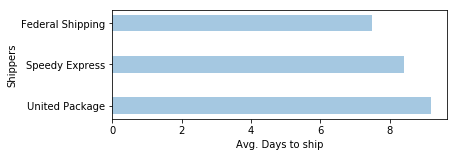

In [49]:
x = [9.2, 8.4,7.5]
y = ["United Package", "Speedy Express", "Federal Shipping"]

plt.figure(figsize=(6,2))
plt.ylabel('Shippers')
plt.xlabel('Avg. Days to ship')
plt.barh(y, x, height=0.4, alpha=0.4);

The shippers do have statistically different ship times. United Package takes the most tts, while Federal Shipping takes the least.

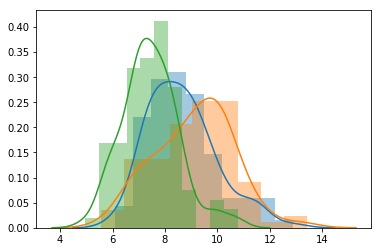

In [50]:
sns.distplot(S1)
sns.distplot(S2)
sns.distplot(S3);

### Case 3: Is there a significant difference in freight cost depending on which shipper you use?

H_o: There is no difference in the cost of freight depending on which shipper you use  
H_a: There is a difference in the cost of freight depending on which shipper you use

In [51]:
cur.execute('''SELECT Id, ShipVia, Freight
               FROM "Order";''')
cost = pd.DataFrame(cur.fetchall())
cost.columns = [i[0] for i in cur.description]

In [52]:
#run ANOVA for Shipper against Freight cost

formula = 'Freight ~ C(ShipVia)'
lm = ols(formula, cost).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df        F    PR(>F)
C(ShipVia)  6.788200e+04    2.0  2.49781  0.082885
Residual    1.123753e+07  827.0      NaN       NaN


In [53]:
#calculate the bonferr
bc_pval3 = 0.05/3
bc_pval3

0.016666666666666666

There are 3 shippers so the adjusted p-value we need to test against is 0.0167. The initial ANOVA speculation showed a p-value greater than that (0.083). There seems to be literature that states even when non-siginificant ANOVA results present, there is some possibility that we could find differences in the mean between some of the group means. I'll proceed with more detailed analysis.

In [54]:
#I separate the data into groups based on which shipper was used.
cost1 = cost[cost['ShipVia'] == 1]
cost2 = cost[cost['ShipVia'] == 2]
cost3 = cost[cost['ShipVia'] == 3]

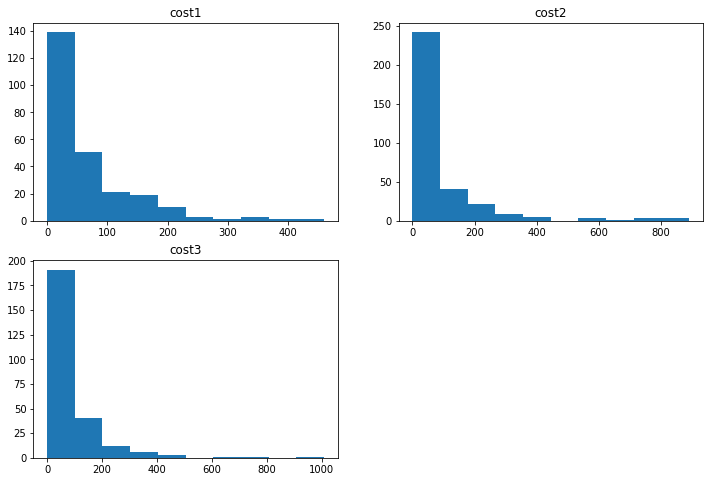

In [55]:
fig = plt.figure(figsize=(12,8))

for i in range(1,4):
    cost0 = cost[cost['ShipVia'] == i]
    ax = fig.add_subplot(2,2,i)
    ax.hist(cost0['Freight'])
    ax.set_title('cost{}'.format(i))
    
plt.show()

The data for the cost of Freight by shipper do not appear to be normally distributed.

In [56]:
for i in [cost1, cost2, cost3]:
    print(stats.shapiro(i.Freight), len(i))

(0.7692915201187134, 2.024363869389547e-18) 249
(0.5826082229614258, 2.954606683318374e-27) 326
(0.6275749802589417, 3.371958171463351e-23) 255


p-value is < 0.05 for each of the distributions of freight cost, so in all cases we reject the null that they are normally distributed. We have to sample, sample mean, and ttest

In [57]:
C1 = get_sample_mean(cost1.Freight)
C2 = get_sample_mean(cost2.Freight)
C3 = get_sample_mean(cost3.Freight)

stats.levene(C1, C2, C3)

LeveneResult(statistic=12.087664804642115, pvalue=8.976751798165905e-06)

We take 100 samples of 30 and take the mean of each of those samples. I run the levene test to determine if they are from a population that has the same variance. I have a p-value of significantly lower than 0.05 which means I have evidence to reject the null that they are from the same variance.

In [58]:
costcombs = [['Speedy Express & United Package',(C1,C2)], ['Speedy Express & Federal Shipping', (C1, C3)], ['United Package & Federal Shipping', (C2,C3)]]

for i in costcombs:
    if stats.levene(i[1][0], i[1][1])[1] < 0.05:
        print('The population of mean freight costs between shippers {} do not have the same variance. That means we will perform Welchs t-test'.format(i[0]))
        ttest = stats.ttest_ind(i[1][0], i[1][1], equal_var=False)
        if ttest[1] < 0.05:
            print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean shipping costs between shippers {} are not statistically different'.format(ttest[1],i[0]))
        else:
            print('The p-value for the ttest is {} which is greater than 0.05. That means I do not have sufficient evidence to reject the null hypothesis, inherently accepting there is no difference between mean shipping costs between shippers {}.'.format(ttest[1],i[0]))
    else:
        print('The population of mean freight costs between shippers {} have the same variance. That means we will perform Students t-test'.format(i[0]))
        ttest = stats.ttest_ind(i[1][0], i[1][1])
        if ttest[1] < 0.05:
            print('The p-value for the ttest is {} which is less than 0.05. That means I will reject the null hypothesis that the mean shipping costs between shippers {} are not statistically different'.format(ttest[1],i[0]))
        else:
            print('The p-value for the ttest is {} which is greater than 0.05. That means I do not have sufficient evidence to reject the null hypothesis, inherently accepting there is no difference between mean shipping costs between shippers {}.'.format(ttest[1],i[0]))

The population of mean freight costs between shippers Speedy Express & United Package do not have the same variance. That means we will perform Welchs t-test
The p-value for the ttest is 1.5061755965186574e-12 which is less than 0.05. That means I will reject the null hypothesis that the mean shipping costs between shippers Speedy Express & United Package are not statistically different
The population of mean freight costs between shippers Speedy Express & Federal Shipping do not have the same variance. That means we will perform Welchs t-test
The p-value for the ttest is 2.1398046442493757e-10 which is less than 0.05. That means I will reject the null hypothesis that the mean shipping costs between shippers Speedy Express & Federal Shipping are not statistically different
The population of mean freight costs between shippers United Package & Federal Shipping have the same variance. That means we will perform Students t-test
The p-value for the ttest is 0.22401207982686386 which is gre

In [59]:
for i in costcombs:
    cd = cohens_d(i[1][0], i[1][1])
    power = power_analysis.solve_power(effect_size=cd, nobs1=30, alpha=.05)
    if power < 0.8:
        print('The effect size between mean shipping costs for {} is {}. Given our sample size of 30, and an alpha level of 0.05, power is determined to be {}'.format(i[0], cd, power))
        print('Given that effect size, we would need to increase sample size to {} in order to meet a power level of 0.8'.format(power_analysis.solve_power(effect_size=cd, alpha=.05, power = 0.8)))
    else:
        print('The effect size between mean shipping costs for {} is {}. Given our sample size of 30, and an alpha level of 0.05, power is determined to be {}'.format(i[0], cd, power))

The effect size between mean shipping costs for Speedy Express & United Package is 1.0970055732698758. Given our sample size of 30, and an alpha level of 0.05, power is determined to be 0.9867017832022683
The effect size between mean shipping costs for Speedy Express & Federal Shipping is 0.9632073808318252. Given our sample size of 30, and an alpha level of 0.05, power is determined to be 0.9561882448917474
The effect size between mean shipping costs for United Package & Federal Shipping is 0.172498134017786. Given our sample size of 30, and an alpha level of 0.05, power is determined to be 0.100741739787746
Given that effect size, we would need to increase sample size to 528.5171603682387 in order to meet a power level of 0.8


In [60]:
for i in [C1, C2, C3]:
    print(mean(i), std(i))

62.549276666666685 13.31037498044748
86.41179 27.562748804285143
81.86043333333333 24.873760602445657


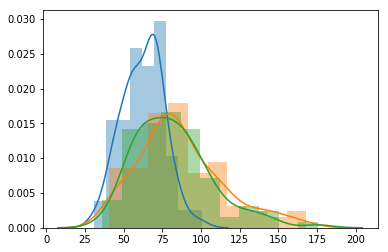

In [61]:
sns.distplot(C1)
sns.distplot(C2)
sns.distplot(C3);

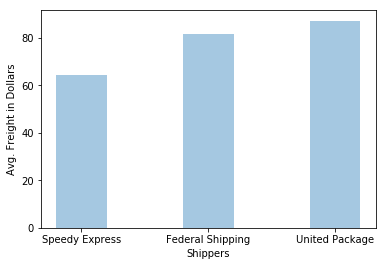

In [62]:
x = {'Speedy Express': 64.6, 'Federal Shipping': 81.6, 'United Package': 87.3}

plt.xlabel('Shippers')
plt.ylabel('Avg. Freight in Dollars')
plt.bar(x.keys(), x.values(), width=0.4, alpha = 0.4);

Speedy Express (1) seems to have significantly lower cost for Freight than United Package(2) and Federal Shipping(3).

### Case 4: Does receiving a discount on an inital sale prove to be a good customer retention method?

H_o: There is no difference in number of lifetime orders between customers who receive a discount on their first purchase vs those who don't receive a discount on their first order.
H_a: There is a difference in number of lifetime orders between customers who receive a discount on their first purchase vs those who don't receive a discount on their first order.

In [63]:
#create a dataframe with the customer's first orders

cur.execute('''SELECT Id, CustomerId, OrderDate
               FROM "Order"
               ORDER BY OrderDate;''')
date = pd.DataFrame(cur.fetchall())
date.columns = [i[0] for i in cur.description]

date = date.drop_duplicates('CustomerId')

We know there are 91 customer IDs. 89 made at least one purchase. Did receiving a discount on the first order make them more likely to become long time customers?

In [64]:
#combine first orders with a df that has a y/n for discount received on the order

o = pd.DataFrame(OrderDetail.groupby('OrderId').Discount.sum()).reset_index()
odeets = pd.merge(OrderDetail, o, left_on='OrderId', right_on='OrderId', how='left')
odeets['disc'] = np.where(odeets.Discount_y > 0,1,0)
odeets = odeets[['OrderId', 'disc']]

first_sale = pd.merge(date, odeets, left_on='Id', right_on='OrderId', how='left')
first_sale = first_sale.drop_duplicates()
first_sale['disc'].value_counts()

0    59
1    30
Name: disc, dtype: int64

30 first sales received some discount, 59 did not. Were the 30 more likely to return as repeat customers?

830 orders - how many per customer?

In [65]:
ccount = pd.DataFrame(Ordr.CustomerId.value_counts()).reset_index()

first_sale = pd.merge(first_sale, ccount, left_on='CustomerId', right_on='index')
first_sale['ordCount'] = first_sale['CustomerId_y']
first_sale = first_sale.drop('CustomerId_y', axis=1)

In [66]:
#ANOVA on whether discount for first sale sees customers return for more future orders
formula = 'ordCount ~ C(disc)'
lm = ols(formula, first_sale).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq    df          F        PR(>F)
C(disc)    801.134743   1.0  32.113073  1.853812e-07
Residual  2170.415819  87.0        NaN           NaN


In [67]:
bc_pval4 = 0.05/2
bc_pval4

0.025

There are 2 options, either the customer received a discount on their first order or they didn't, so the adjusted p-value we need to test against is 0.025. The initial ANOVA speculation showed a p-value less than that (1.85e-07). I'll proceed with more detailed analysis.

In [68]:
nodis = first_sale[first_sale['disc'] == 0]
ydis = first_sale[first_sale['disc'] == 1]

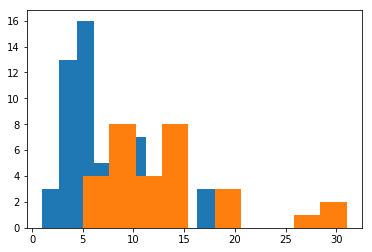

In [69]:
plt.hist(nodis.ordCount)
plt.hist(ydis.ordCount);

Due to the limited data that we have - there are only 89 customers who have made a purchase - we cannot take the normal approach of creating a distribution of sample means to create normality. Instead I will use the bootstrapping method to generate a combined universal population and then sample at random from that universal population 10,000 times to generate two samples of size equal to the original two groups. I will then compare the means of the new samples and see what the likelihood is the original difference in means was significant.

In [70]:
def bootstrap(A, B):
    universe = list(A) + list(B)
    universe_shuffled = np.random.choice(universe, size=len(universe), replace=True)
    new_a = universe_shuffled[:len(A)]
    new_b = universe_shuffled[len(A):]
    return new_a, new_b

In [71]:
a = ydis.ordCount
b = nodis.ordCount

In [72]:
iterations = 10**4
diff_mu_a_b = np.mean(a) - np.mean(b)
num = 0 #Initialize numerator
for n in range(iterations):
    ai, bi = bootstrap(a, b)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))

P-value: 0.0


In [73]:
print(mean(a), std(a))
print(mean(b), std(b));

13.533333333333333 6.406940680924781
7.186440677966102 3.989284699789227


In [74]:
13.533 - 7.186

6.3469999999999995

In [75]:
cd = cohens_d(a, b)
power = power_analysis.solve_power(effect_size=cd, nobs1=30, alpha=.05)
print('The effect size between number of orders received from a customer if they received a discount on their first order versus if they did not is {}. Given our sample sizes of {} (dicount on first sale) and {} (no discount), with 10000 samples drawn, and an alpha level of 0.05, our power is determined to be {}'.format(cd, len(a), len(b), power))

The effect size between number of orders received from a customer if they received a discount on their first order versus if they did not is 1.270718364488709. Given our sample sizes of 30 (dicount on first sale) and 59 (no discount), with 10000 samples drawn, and an alpha level of 0.05, our power is determined to be 0.9980026258381248


It is clear that customers who receive a discount on their initial order are more likely to remain customers and place more orders than those customers who do not receive a discount on their first order.